In [1]:
import numpy as np
from sklearn import preprocessing, cluster
import pandas
from matplotlib import pyplot
import matplotlib

import podomics

## Loading a dataset

In [2]:
omics = podomics.read_csv("examples/exampledata3.csv", sample="Sample", time="Timepoint", condition="Condition")
print(omics.data.head())
print("Timepoints:", omics.timepoints)

       Condition  Timepoint        10        43         2         0        16  \
Sample                                                                          
aT0R0          a       0.00  0.294415  0.012780  0.988288  1.000774  0.070487   
aT0R2          a       0.00  0.293859  0.006343  0.922625  1.059388  0.145908   
aT0R1          a       0.00  0.351795  0.010958  0.982960  1.008382  0.029968   
aT1R0          a       0.25  0.307706  0.132628  0.776740  0.807937  0.109115   
aT1R2          a       0.25  0.304130  0.146054  0.739624  0.813807  0.067468   

              30        33        48  ...        21        45        36  \
Sample                                ...                                 
aT0R0   0.033389  0.097109  0.042608  ...  0.115557  0.062764  0.059689   
aT0R2   0.014464  0.002039  0.020438  ...  0.079815  0.023210  0.018816   
aT0R1   0.050681  0.021210  0.038401  ...  0.033762  0.090298  0.034470   
aT1R0   0.033649  0.012068  0.241186  ...  0.036998  0.21

## Data rescaling

The recommended way to rescale the data is to divide each feature by a typical value, for example its maximum or median value. A good alternative can be a log-scaling. The implementations of these methods is illustrated below.

z-score normalization or similar is not recommended, since it removes difference in variance among features that may contain relevant timeseries information.

### Scaling by maximum value

Scaling with maximum value is the default in podomics and can be achieved by calling the `rescale()` method without any parameters.

In [3]:
omics_maxscaled = omics.rescale()
np.array([omics_maxscaled.data[f].max() for f in omics_maxscaled.features])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The output shows that all features in the rescaled dataset have a maximum value of 1.

### Scaling by median

Unfortunately there is now median scaler in the `sklearn.preprocessing` currently. We provide a custom `MedianScaler` class in the `dataset` module, that closely follows the implementation of the `MaxAbsScaler` class.

An instance of the `MedianScaler` class has to be passed to the `rescale()` method to do a scaling wit the median.

In [4]:
omics_medscaled = omics.rescale(method=podomics.dataset.MedianScaler())
np.array([omics_medscaled.data[f].median() for f in omics_medscaled.features])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

The output shows that all features in the rescaled dataset have a median value of 1.

### Log scaling

TODO, use sklearn.preprocessing.FunctionTransformer

## Data plotting

(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Condition a'}, xlabel='Feature index', ylabel='Feature values'>,
        <AxesSubplot: title={'center': 'Condition b'}, xlabel='Feature index'>],
       dtype=object))

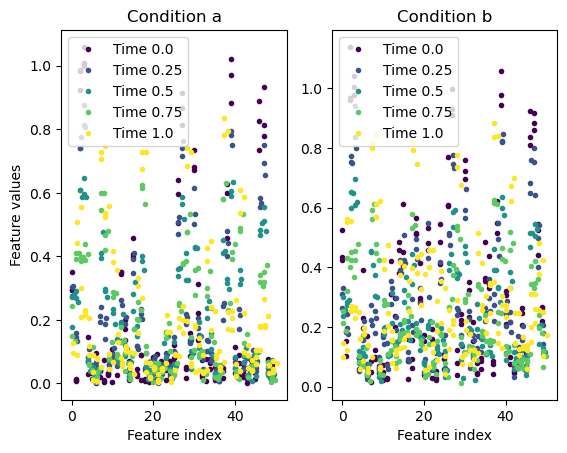

In [5]:
omics.plot(condition=["a", "b"])

Text(0.5, 1.0, 'Median scaled data - a')

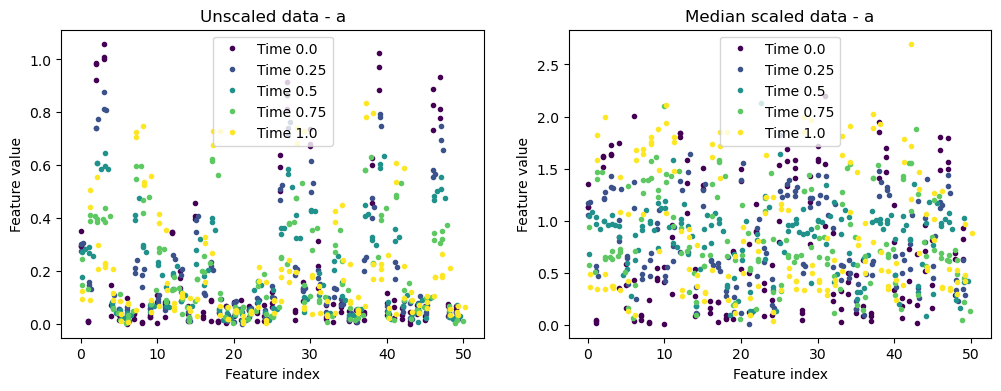

In [6]:
fig, axs = pyplot.subplots(1, 2, figsize=(12, 4))
omics.plot(ax=axs[0], condition="a")
omics_medscaled.plot(ax=axs[1], condition="a")
for ax in axs:
    ax.set_xlabel("Feature index")
    ax.set_ylabel("Feature value")
axs[0].set_title("Unscaled data - a")
axs[1].set_title("Median scaled data - a")

## POD computation

In the simplest version, a call to `podomics.POD` with a dataset as only argument runs the POD on all features and all samples. The results are immediately computed and stored in the created object's attributes. The results can then be further analysed with the plotting and analysis methods provided by the `POD` class.

Further relevant options are:
- **Clustering of features:** Pass a suitable method for clustering from the [`sklearn.cluster`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) module.
  Recommended methods are [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
  Use the `cluster_components` keyword argument to the `POD` constructor to indicate the number of singular vectors / principal components to include in the cluster (counted from the first component in order of decreasing weight).
- **Selection of a subset of conditions:** to do the POD only for a part of the samples based on condition, pass a list with the identifiers of the relevant conditions as the `conditions` keyword argument to the `POD` constructor.
- **Selection of a subset of features:** pass a list with features for which to do the analysis as the `features` keyword argument to the `POD` constructor.

The call below runs a POD on the above dataset for the "a" condition only, but for all features.
It does clustering using `KMeans` using the first three components.
Note that the number of clusters to compute is fixed independently to 2 during the construction of the `KMeans` object.

In [7]:
import sklearn
cluster_method = cluster.KMeans(n_clusters=3, n_init='auto')
pod = podomics.POD(omics_medscaled, cluster=cluster_method, cluster_components=3)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Component index', ylabel="<ufunc 'log'> singular values">)

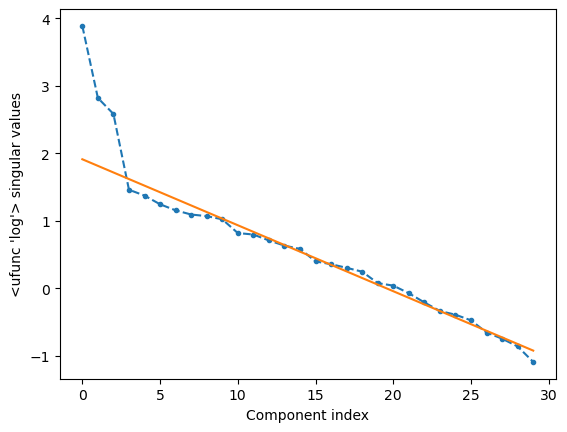

In [8]:
pod.plot_singular_values(trafo=np.log, fit_line=0.7)

Text(0, 0.5, 'Component 2')

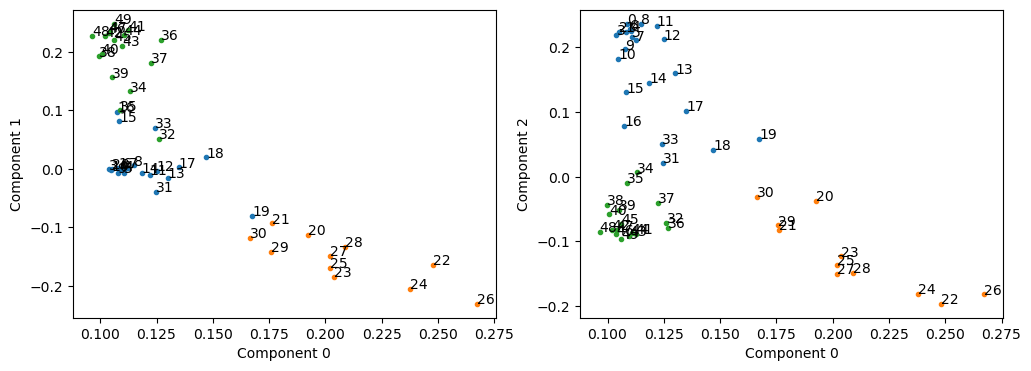

In [9]:
fig, axs = pyplot.subplots(1, 2, figsize=(12,4))
pod.plot_features(axs[0], components=(0, 1), labels=True)
pod.plot_features(axs[1], components=(0, 2), labels=True)
axs[0].set_xlabel("Component 0")
axs[0].set_ylabel("Component 1")
axs[1].set_xlabel("Component 0")
axs[1].set_ylabel("Component 2")

In [10]:
average_weights = pod.interpolate_sample_weights()
average_weights

,Condition,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
Timepoint,,,,,,,,,,,,,,,,,,,,,
0.00,a,0.099993,0.013048,0.348099,0.044480,0.031231,0.126508,0.004478,0.178243,-0.101073,...,0.058127,-0.023609,0.179952,-0.072221,-0.043506,-0.077560,-0.047595,-0.040367,0.137174,0.024587
0.25,a,0.102333,0.093272,0.260256,-0.035069,-0.065501,0.074228,-0.003568,-0.046823,0.033601,...,0.011670,-0.048490,-0.199145,0.127543,0.086761,0.120046,-0.119017,-0.049455,0.131232,-0.017188
0.50,a,0.102413,0.160956,0.146620,0.030827,0.060637,-0.001668,-0.019432,-0.049353,0.031883,...,-0.106757,0.011698,-0.084847,-0.120394,-0.025223,0.117671,0.075824,0.154962,-0.347897,0.004755
0.75,a,0.104566,0.232158,0.034120,-0.104391,-0.027824,-0.015898,-0.073885,-0.185178,0.059789,...,0.010651,-0.013172,0.125153,0.098431,0.125598,-0.079758,0.058426,-0.032635,-0.020067,-0.065741
1.00,a,0.113679,0.300493,-0.047681,0.031977,-0.017122,-0.092345,0.135442,-0.065490,-0.017301,...,0.032770,0.035056,0.162345,-0.083929,-0.001687,0.020398,-0.089478,-0.034522,0.006029,-0.039247
0.00,b,0.293948,-0.314145,0.058003,0.041518,-0.037573,-0.207798,0.149012,-0.224326,-0.018811,...,-0.052167,0.031556,0.046931,0.017675,0.061748,0.023750,0.010554,0.005183,0.012810,0.019069
0.25,b,0.256466,-0.170348,-0.011150,-0.164264,0.037534,0.205474,-0.161928,0.095401,0.065337,...,0.087857,-0.015571,0.005527,-0.069064,0.030999,-0.053116,0.006210,0.000516,-0.132898,-0.110952
0.50,b,0.164676,0.056660,0.055932,0.101097,0.024939,-0.109158,0.000486,0.155799,-0.033004,...,-0.092031,0.062353,-0.035839,0.107202,-0.247599,0.032915,0.106327,0.015482,-0.023048,0.121473
0.75,b,0.161977,0.121860,-0.060070,-0.033369,0.062841,-0.147036,-0.093365,0.051886,0.074563,...,0.066371,0.024779,-0.222610,-0.015183,0.019890,-0.210959,0.088335,0.008561,0.164352,0.065104


In [11]:
df = pod.sample_weights
[df[df[pod.ds.condition]==c] for c in pod.ds.condition_list]
# [df[df[pod.ds.condition]==c].groupby(pod.ds.time).mean() for c in pod.ds.condition_list]

[       Condition  Timepoint         0         1         2         3         4  \
 Sample                                                                          
 aT0R0          a       0.00  0.105564  0.026577  0.328774  0.237620 -0.155835   
 aT0R2          a       0.00  0.095276 -0.001033  0.345069 -0.101495  0.234271   
 aT0R1          a       0.00  0.099139  0.013600  0.370454 -0.002684  0.015258   
 aT1R0          a       0.25  0.106454  0.100217  0.267633 -0.142970 -0.097650   
 aT1R2          a       0.25  0.097393  0.080576  0.245501  0.025363  0.108938   
 aT1R1          a       0.25  0.103153  0.099022  0.267633  0.012400 -0.207793   
 aT2R2          a       0.50  0.103626  0.168579  0.156992  0.048306  0.146912   
 aT2R1          a       0.50  0.097888  0.159036  0.134264  0.043589 -0.018125   
 aT2R0          a       0.50  0.105724  0.155253  0.148604  0.000586  0.053125   
 aT3R2          a       0.75  0.102631  0.273951  0.048910 -0.104780 -0.054556   
 aT3R0          

In [12]:
pod_result = podomics.POD(podomics.read_csv("examples/exampledata1.csv", sample="Sample"))
average_weights = pod_result.interpolate_sample_weights()

In [13]:
print(average_weights.iloc[:2,:3])

                  0         1         2
Timepoint                              
0.00      -0.307343 -0.320584  0.245403
0.25      -0.279958 -0.144988 -0.251014


(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Component #1'}, xlabel='Timepoint', ylabel='Weight'>,
        <AxesSubplot: title={'center': 'Component #2'}, xlabel='Timepoint'>],
       dtype=object))

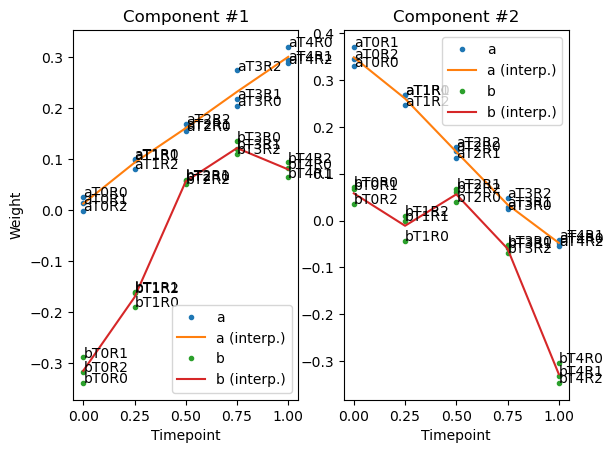

In [14]:
pod.plot_sample_weights(interpolate=True, components=[1, 2], labels=True)